# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

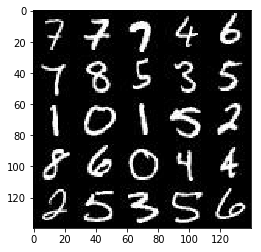

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

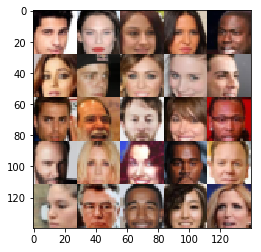

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # following course materials
    alpha=0.2
    init=tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=init)
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64       
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=init)
        # shifting inputs to zero-mean and unit variance
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128  
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=init)
        # shifting inputs to zero-mean and unit variance
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 7x7x256
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # following course materials; but different dimensions
    alpha=0.2
    init=tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same', kernel_initializer=init)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=init)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # following course materials
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # following course materials
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 20
    show_every = 100
    
    losses = []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)      
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # Rescaling input
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))  
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                     lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode) 
                    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8979... Generator Loss: 0.1013
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 1.8355... Generator Loss: 0.3328
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 1.7958


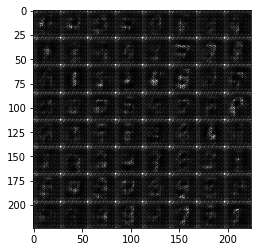

Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 1.6991
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.4708


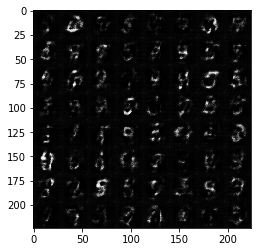

Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.6014
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.4149
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.2325


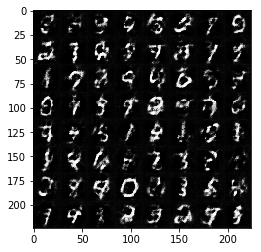

Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.3573
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 2.4791
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 0.9649


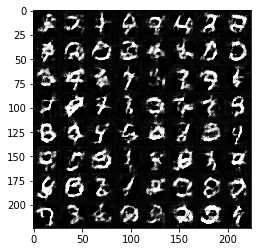

Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.8818
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.0395


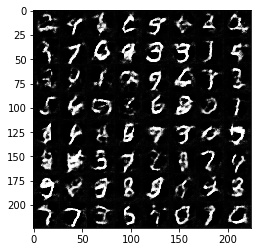

Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 1.5840
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.4720
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.6988


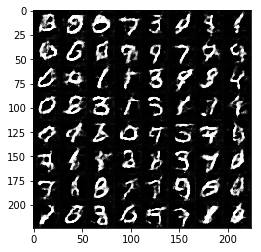

Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.4689
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.8522


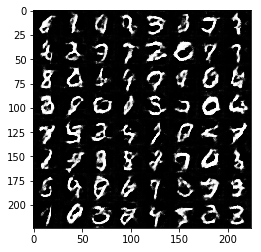

Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 0.9029
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 1.7084
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 1.8276... Generator Loss: 0.3663
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 0.9892


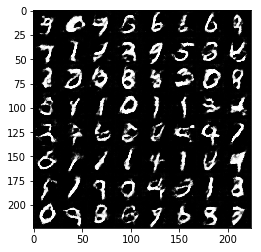

Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.5085
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 0.6351


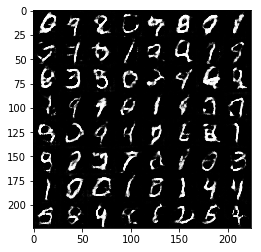

Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.6374


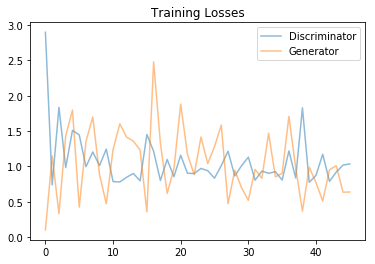

In [12]:
"""
With current hyperparameters I was getting too high generator loss (and pictures were not that good):

    batch_size = 128
    z_dim = 100
    learning_rate = 0.0002
    beta1 = 0.5

Was trying to modify learning rate and other parameters.
It did not help much (generator loss kept staying (sometimes much) higher than discriminator loss).
Also, evaluating took a lot of time

After doing some reading (articles & forum), ended up:
    - adding one extra layer to generator and keeping original hyperparameters;
    - using xavier_initializer as weight initialization
    
The results turned out much better looking as well (but training was slower because of extra layer).
Not perfect, but ok. The loss graph could be better...

Possible improvements:
(not going to implement it, had to close my AWS instance because I exceeded my free credit limit)

- adding dropout (like in paper on DCGAN´s by Alec Radford, Luke Metz, Soumith Chintala)
- adding more layers to discriminator
"""

batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
## following the training material

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 2.8361


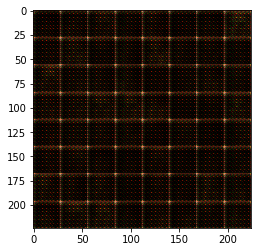

Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 2.1377
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 2.1104


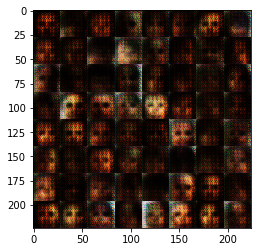

Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.6952... Generator Loss: 1.7586
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 1.8632
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.3492


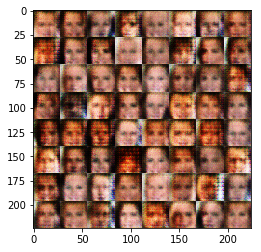

Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7189


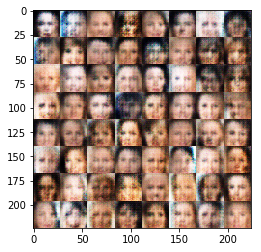

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8808


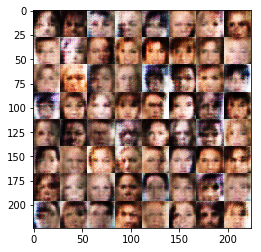

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.4977


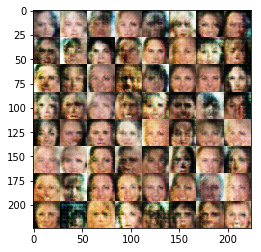

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7761


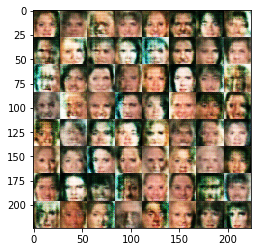

Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8493


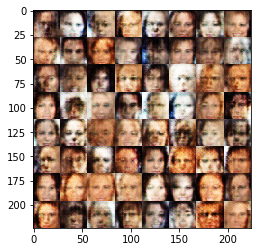

Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.4245


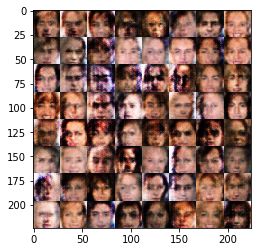

Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8545


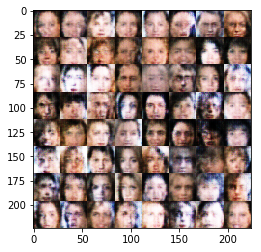

Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9041


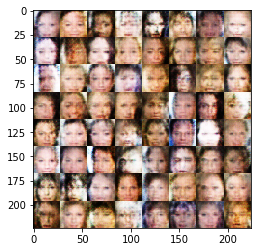

Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.0400


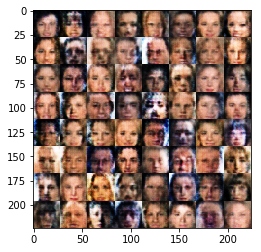

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.9934


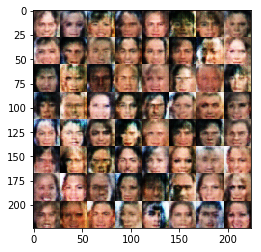

Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8950


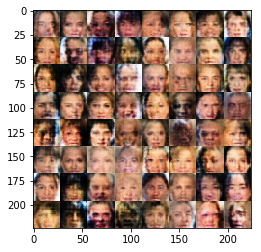

Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7685


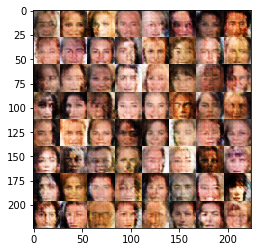

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8814


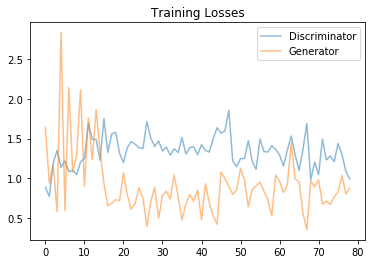

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
## following the training material


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.